In [2]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import pickle
import numpy as np
from datasets_batched import NUS_WIDE_KNN
from torchvision import transforms
import torchvision as tv
from torch.utils.data.sampler import SubsetRandomSampler
import csv

# Preparation

In [41]:
# loading pretrained model
model = pickle.load(open("pickles/models/entire_nuswide_model_2.p", "rb"))
word_vec_dict = pickle.load(open("pickles/word_embeddings/word_embeddings_tensors.p", "rb"))

# loading up filtered_text labels:
with open('labels.csv') as f:
    reader = csv.reader(f)
    NUS_WIDE_classes = [i[0] for i in list(reader)]
        
# init dataset
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
data_path = 'NUS_WIDE'

dataset = NUS_WIDE_KNN(data_path,
    transforms.Compose([tv.transforms.Resize((224,224)), transforms.ToTensor(),
                                 transforms.Normalize(mean,std)]), NUS_WIDE_classes)

# init loaders
batch_size = 256
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 8, 'pin_memory': True} if cuda else {}
data_loader = torch.utils.data.DataLoader(dataset,  batch_size=batch_size, **kwargs)


# Making database for FAISS index

In [42]:
# returns matrix of embeddings for FAISS and matrix s.t. faiss idx -> o.g. dataset idx
def make_db(model, data_loader):
    n = len(data_loader.sampler)
    d = 30 # size of the embeddings outputted by the model
    model.eval()
    
    faiss_db = np.empty((n,d), dtype='float32')
    fidx_to_idx = np.empty(n, dtype=int)
    
    n_idx = 0
    for _, (data, target) in enumerate(data_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple,list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
        target = target.numpy()

                
        embeddings = model.get_embedding(*data)
        
        for idx in range(len(embeddings)):
            faiss_db[n_idx + idx, :] = embeddings[idx].cpu().detach().numpy()
            fidx_to_idx[n_idx + idx] = target[idx]
        n_idx += len(embeddings)
            
    return faiss_db, fidx_to_idx

In [43]:
base_db, b_indices = make_db(model, data_loader)

# Inference

In [44]:
import faiss
index = faiss.IndexFlatL2(30)
index.add(base_db)

In [45]:
def get_images(query_word, k=10):
    word_vector = word_vec_dict[query_word]
    
    model.eval()
    with torch.no_grad():
        word_embedding = model.get_embedding_word(word_vector.unsqueeze(0).cuda()).data.cpu().numpy()
    
    query = np.asarray(word_embedding)
    _, indices = index.search(query, k)
    
    print(query_word)
    for fidx in indices[0,:]:
        plt.figure()
        plt.imshow(dataset.get_raw_image(b_indices[fidx]))

vegetation


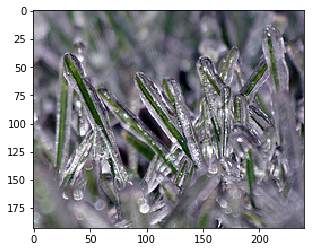

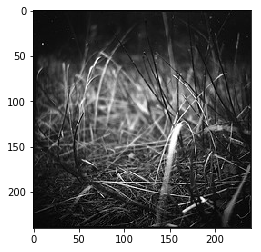

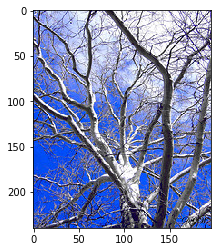

In [64]:
get_images('vegetation',3)